In [1]:
# All libs be imported
import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Setup Logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [2]:
""" All files in src directory """
from market_processing import *
from entities import *

In [3]:
from engine import Engine
from models import DiffusionTransformer
from frameworks import Diffusion

device = "cuda" if torch.cuda.is_available() else "cpu"
window_size = 64
batch_size = 32
epochs = 16
lr = 1e-4
hiden_dim = 128
deep_layers = 2
n_attention_head = 4
ddpm = {
    "noise_steps": 1000,
    "beta_start": 1e-4,
    "beta_end": 0.02,
}

In [4]:
symbols = ['AAPL', 'TSLA', 'MSFT']
basket = AssetBasket(symbols=symbols)
window_size = 64

DEBUG:entities.basket:Initialized Asset Basket: ['AAPL', 'TSLA', 'MSFT'] with 0 assets which loaded.


In [5]:
basket.load_all_assets(freq="1d")

for symbol, asset in basket.assets.items():
    asset.to_returns(log=True, target_features=['Close'])
    vol_series = asset.get_garman_klass_vol(look_back=window_size, annualized=False)
    asset.data[f"Vol_{symbol}"] = vol_series

basket.get_stats_summary()

INFO:entities.basket:Starting batch load for 3 symbols...
DEBUG:entities.basket:Attempting to load AAPL...
DEBUG:entities.asset:Initialized Asset: AAPL with 2724 rows.
INFO:entities.basket:Successfully loaded AAPL (2724 rows).
DEBUG:entities.basket:Attempting to load TSLA...
DEBUG:entities.asset:Initialized Asset: TSLA with 2760 rows.
INFO:entities.basket:Successfully loaded TSLA (2760 rows).
DEBUG:entities.basket:Attempting to load MSFT...
DEBUG:entities.asset:Initialized Asset: MSFT with 2724 rows.
INFO:entities.basket:Successfully loaded MSFT (2724 rows).
INFO:entities.basket:Batch load complete. Success: 3/3. Total assets in basket: 3
DEBUG:entities.asset:AAPL converted to Returns (Log=True)
DEBUG:entities.asset:TSLA converted to Returns (Log=True)
DEBUG:entities.asset:MSFT converted to Returns (Log=True)


,count,mean,std,min,25%,50%,75%,max,skew,kurt
symbol,,,,,,,,,,
AAPL,2723.0,0.000887,0.018264,-0.137708,-0.007422,0.001000,0.010039,0.142617,-0.091082,6.281809
TSLA,2759.0,0.001272,0.036304,-0.236518,-0.016660,0.001261,0.019425,0.204491,-0.056569,4.357829
MSFT,2723.0,0.000947,0.016983,-0.159454,-0.006668,0.000958,0.009423,0.132929,-0.098976,8.165358
TOTAL_AVG,8205.0,0.001035,0.023850,-0.177893,-0.010250,0.001073,0.012962,0.160012,-0.082209,6.268332


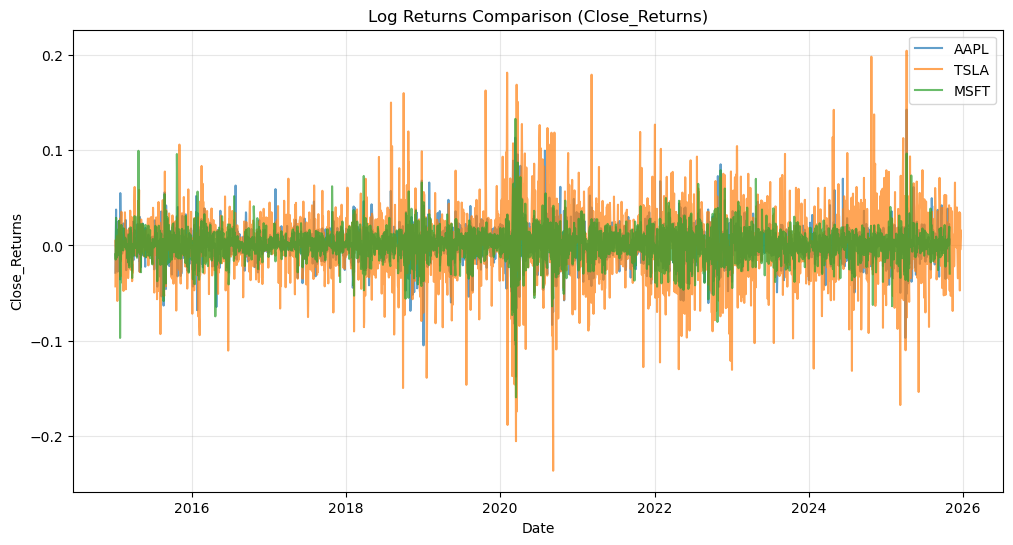

In [6]:
basket.plot_assets(title='Log Returns Comparison')

In [7]:
# strategy = StrictAlignment()
strategy = MarketFeatureAlignment()
joint_df = basket.get_joint_data(strategy)
joint_df.head()

DEBUG:market_processing.strategies.concrete:Symbol: AAPL, DataFrame Column Names: ['Close', 'High', 'Low', 'Open', 'Volume', 'Close_Returns', 'Vol_AAPL'], Selected Columns: ['Close_Returns', 'Vol_AAPL']
DEBUG:market_processing.strategies.concrete:Symbol: TSLA, DataFrame Column Names: ['Close', 'High', 'Low', 'Open', 'Volume', 'Close_Returns', 'Vol_TSLA'], Selected Columns: ['Close_Returns', 'Vol_TSLA']
DEBUG:market_processing.strategies.concrete:Symbol: MSFT, DataFrame Column Names: ['Close', 'High', 'Low', 'Open', 'Volume', 'Close_Returns', 'Vol_MSFT'], Selected Columns: ['Close_Returns', 'Vol_MSFT']
DEBUG:entities.basket:Aligned data shape: (2660, 6)


,AAPL_Close_Returns,Vol_AAPL,TSLA_Close_Returns,Vol_TSLA,MSFT_Close_Returns,Vol_MSFT
Date,,,,,,
2015-04-07,-0.010578,0.012762,0.000738,0.020798,-0.000481,0.011548
2015-04-08,-0.003259,0.012605,0.021514,0.020604,-0.002652,0.011595
2015-04-09,0.007614,0.012455,0.011586,0.020243,0.001447,0.011447
2015-04-10,0.004258,0.012455,0.003848,0.020182,0.005770,0.011359
2015-04-13,-0.001969,0.012328,-0.005325,0.020202,0.000958,0.011348


In [8]:
# # 2. Align Data (รวมร่าง)
#     # ใช้ StrictAlignment เพื่อเอาเฉพาะวันที่ตลาดเปิดตรงกัน

    
#     print(f"Joint Data Shape: {joint_df.shape}")
#     # columns จะเป็น [AAPL_Close_ret, MSFT_Close_ret]
    
#     # 3. Preprocess for Model (Scale & Window)
#     processor = MarketPreprocessor(window_size=60, train_split=0.8)
#     X_train, X_test = processor.fit_transform(joint_df)

In [9]:
dm = MarketDataModule(
        joint_df=joint_df,
        window_size=window_size,
        batch_size=batch_size,
        use_stats_features=True,
        split_ratio=(0.7, 0.2, 0.1)
    )

In [10]:
dm.setup()

INFO:market_processing.data_module:Setting up MarketDataModule...
DEBUG:market_processing.data_module: Use states featyres: True, DataFrame Index: DatetimeIndex(['2015-04-07', '2015-04-08', '2015-04-09', '2015-04-10',
               '2015-04-13', '2015-04-14', '2015-04-15', '2015-04-16',
               '2015-04-17', '2015-04-20',
               ...
               '2025-10-17', '2025-10-20', '2025-10-21', '2025-10-22',
               '2025-10-23', '2025-10-24', '2025-10-27', '2025-10-28',
               '2025-10-29', '2025-10-30'],
              dtype='datetime64[ns]', name='Date', length=2660, freq=None), Num of DataFrame: 2660
DEBUG:market_processing.features.feature_engineer:Processing Features: 3 Vol cols, 3 Return cols
DEBUG:market_processing.data_module: Num of Stats DataFrame: 2597
DEBUG:market_processing.data_module: Split sizes - Train: 1817, Val: 520, Test: 260
INFO:market_processing.data_module: MarketDataModule setup complete.


In [11]:
dm._clean_and_inspect_features(dm.stats_df)

INFO:market_processing.data_module:====== Inspection: Data ======
INFO:market_processing.data_module:  > Shape: (2597, 6)
INFO:market_processing.data_module:  > Columns: [Vol_AAPL, Vol_TSLA, Vol_MSFT, Corr_AAPL_TSLA, Corr_AAPL_MSFT, Corr_TSLA_MSFT]
DEBUG:market_processing.data_module:  > Head (First 3 rows):
            Vol_AAPL  Vol_TSLA  Vol_MSFT  Corr_AAPL_TSLA  Corr_AAPL_MSFT  Corr_TSLA_MSFT
Date                                                                                    
2015-07-07  0.009711  0.017351  0.011513        0.175826        0.429251       -0.017835
2015-07-08  0.009690  0.017362  0.011568        0.257331        0.419440       -0.009890
2015-07-09  0.009974  0.017355  0.011565        0.244495        0.400273       -0.004060
INFO:market_processing.data_module:===================================


,Vol_AAPL,Vol_TSLA,Vol_MSFT,Corr_AAPL_TSLA,Corr_AAPL_MSFT,Corr_TSLA_MSFT
Date,,,,,,
2015-07-07,0.009711,0.017351,0.011513,0.175826,0.429251,-0.017835
2015-07-08,0.009690,0.017362,0.011568,0.257331,0.419440,-0.009890
2015-07-09,0.009974,0.017355,0.011565,0.244495,0.400273,-0.004060
2015-07-10,0.010037,0.017337,0.011580,0.234035,0.387447,-0.004101
2015-07-13,0.010013,0.017447,0.011559,0.240492,0.403510,0.004185
...,...,...,...,...,...,...
2025-10-24,0.013030,0.024029,0.009663,0.372085,0.148818,0.280910
2025-10-27,0.013043,0.024023,0.009674,0.391427,0.168944,0.307084
2025-10-28,0.012993,0.024108,0.009788,0.383237,0.160427,0.311957


In [12]:
train_dataloader = dm.train_dataloader()
val_dataloader = dm.validate_dataloader()
test_dataloader = dm.test_dataloader()

X, y = next(iter(train_dataloader))
y.shape

torch.Size([32, 64, 6])

In [13]:
model = DiffusionTransformer(
    features_in=X.shape[2],
    d_model=hiden_dim,
    num_layers=deep_layers,
    nhead=n_attention_head,
    max_len=window_size
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr) 
diffusion = Diffusion(
    noise_steps = ddpm["noise_steps"],
    beta_start = ddpm["beta_start"],
    beta_end = ddpm["beta_end"],
    length= window_size,
    channels= X.shape[2],
    device = device
)

In [14]:
engine = Engine(train_dataloader= train_dataloader, val_dataloader=val_dataloader, test_dataloader=test_dataloader, diffusion=diffusion, model=model, optimizer=optimizer, num_epochs_to_save=epochs/2 ,device=device)
engine.fit(epochs=epochs)

history = engine.history

INFO:engine:Engine started! Training for 16 epochs on cuda...
Epoch 0/16: 100%|██████████| 55/55 [00:01<00:00, 38.09it/s, MSELoss=0.2886]
INFO:engine:Epoch 1 | Train Loss: 0.431391 | Val Loss: 0.243483
INFO:root:New Best Model Found! (Val Loss: 0.243483)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0001_20260105_192138.pt


Epoch 1/16: 100%|██████████| 55/55 [00:01<00:00, 49.76it/s, MSELoss=0.2185]
INFO:engine:Epoch 2 | Train Loss: 0.228006 | Val Loss: 0.133621
INFO:root:New Best Model Found! (Val Loss: 0.133621)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0002_20260105_192140.pt


Epoch 2/16: 100%|██████████| 55/55 [00:01<00:00, 49.85it/s, MSELoss=0.2949]
INFO:engine:Epoch 3 | Train Loss: 0.210305 | Val Loss: 0.101671
INFO:root:New Best Model Found! (Val Loss: 0.101671)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0003_20260105_192141.pt


Epoch 3/16: 100%|██████████| 55/55 [00:01<00:00, 49.77it/s, MSELoss=0.1637]
INFO:engine:Epoch 4 | Train Loss: 0.189081 | Val Loss: 0.121887
Epoch 4/16: 100%|██████████| 55/55 [00:01<00:00, 49.41it/s, MSELoss=0.1502]
INFO:engine:Epoch 5 | Train Loss: 0.167073 | Val Loss: 0.098677
INFO:root:New Best Model Found! (Val Loss: 0.098677)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0005_20260105_192144.pt


Epoch 5/16: 100%|██████████| 55/55 [00:01<00:00, 49.51it/s, MSELoss=0.1377]
INFO:engine:Epoch 6 | Train Loss: 0.172420 | Val Loss: 0.137706
Epoch 6/16: 100%|██████████| 55/55 [00:01<00:00, 49.62it/s, MSELoss=0.1672]
INFO:engine:Epoch 7 | Train Loss: 0.162086 | Val Loss: 0.047314
INFO:root:New Best Model Found! (Val Loss: 0.047314)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0007_20260105_192147.pt


Epoch 7/16: 100%|██████████| 55/55 [00:01<00:00, 49.76it/s, MSELoss=0.1607]
INFO:engine:Epoch 8 | Train Loss: 0.157322 | Val Loss: 0.164395
Epoch 8/16: 100%|██████████| 55/55 [00:01<00:00, 50.31it/s, MSELoss=0.1494]
INFO:engine:Epoch 9 | Train Loss: 0.162262 | Val Loss: 0.149923
Epoch 9/16: 100%|██████████| 55/55 [00:01<00:00, 49.76it/s, MSELoss=0.1088]
INFO:engine:Epoch 10 | Train Loss: 0.151094 | Val Loss: 0.372916
Epoch 10/16: 100%|██████████| 55/55 [00:01<00:00, 50.42it/s, MSELoss=0.1211]
INFO:engine:Epoch 11 | Train Loss: 0.156274 | Val Loss: 0.112138
Epoch 11/16: 100%|██████████| 55/55 [00:01<00:00, 50.23it/s, MSELoss=0.0873]
INFO:engine:Epoch 12 | Train Loss: 0.137748 | Val Loss: 0.086767
Epoch 12/16: 100%|██████████| 55/55 [00:01<00:00, 50.42it/s, MSELoss=0.0687]
INFO:engine:Epoch 13 | Train Loss: 0.134033 | Val Loss: 0.200341
Epoch 13/16: 100%|██████████| 55/55 [00:01<00:00, 50.40it/s, MSELoss=0.1033]
INFO:engine:Epoch 14 | Train Loss: 0.144178 | Val Loss: 0.047000
INFO:root:N

✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0014_20260105_192155.pt


Epoch 14/16: 100%|██████████| 55/55 [00:01<00:00, 49.68it/s, MSELoss=0.0661]
INFO:engine:Epoch 15 | Train Loss: 0.137055 | Val Loss: 0.083192
Epoch 15/16: 100%|██████████| 55/55 [00:01<00:00, 50.35it/s, MSELoss=0.1150]
INFO:engine:Epoch 16 | Train Loss: 0.128266 | Val Loss: 0.041777
INFO:root:New Best Model Found! (Val Loss: 0.041777)


✅ Checkpoint saved successfully to: /home/narodom.y@FUSION.LAB/research/results/checkpoints/ddpm_diffusiontransformer_0016_20260105_192158.pt


In [15]:
x_fake = diffusion.sample(model, n=len(test_dataloader)).cpu().numpy()
x_fake

INFO:root:Sampling 7 new time series windows....
999it [00:02, 416.27it/s]


array([[[ 1.48809409e+00,  8.47914791e+00,  1.36761246e+01,
          6.34577990e+00,  6.06096268e+00,  3.87121415e+00],
        [-3.63737047e-01,  5.04476643e+00,  9.11855984e+00,
          5.08646488e+00,  5.58167315e+00,  3.46111107e+00],
        [ 1.46663940e+00,  7.60327721e+00,  1.03979158e+01,
          5.41751862e+00,  5.96580696e+00,  4.44166470e+00],
        ...,
        [ 5.98155677e-01,  7.21274996e+00,  1.13424091e+01,
          3.82495379e+00,  6.84650373e+00,  4.14258957e+00],
        [ 1.44502163e+00,  8.24421406e+00,  1.26759462e+01,
          6.13466549e+00,  5.84124327e+00,  4.10170221e+00],
        [-2.13220286e+00,  3.38408041e+00,  5.58190012e+00,
          4.62065983e+00,  5.10367107e+00,  4.04523277e+00]],

       [[-1.61102021e+00, -5.86686730e-01, -7.87840486e-01,
         -3.59387493e+00, -2.19213510e+00, -1.97165382e+00],
        [-1.26402605e+00, -6.46607161e-01, -8.15008283e-01,
         -2.22173977e+00, -2.05673313e+00, -1.24537396e+00],
        [-9.86721